In [1]:
%reset -f
%matplotlib qt
import sys
import mne as mne
import matplotlib.pyplot as plt
import numpy as np
import os.path as op
import os
import warnings
warnings.filterwarnings('ignore')
import pandas as pd

#%load_ext autoreload
#%autoreload 2
%run EEG_auxiliary_module.ipynb
%run general_tools.ipynb
mne.__version__
mne.set_log_level("WARNING")

infolder, outfolder = find_folder()

conf = dict()

# EEG parameters
resample = 200

In [43]:
%run EEG_auxiliary_module.ipynb
# Defining triggers
trigs=list(range(101, 151))+list(range(201, 251))
event_ids={str(x):x for x in trigs}

In [23]:
# Loading raws
# Defining montage
montage = mne.channels.read_montage("standard_1020")

# Loading
file_name='IR_10_S01.bdf'
fname = op.join(infolder,file_name)
raw_1 = mne.io.read_raw_edf(fname,montage=montage, preload=True, verbose = True)
file_name='IR_10_S02.bdf'
fname = op.join(infolder,file_name)
raw_2 = mne.io.read_raw_edf(fname,montage=montage, preload=True, verbose = True)
raw = mne.concatenate_raws([raw_1,raw_2])
del raw_1, raw_2
events = mne.find_events(raw)
raw.filter(0.1, 30, fir_design='firwin')
raw.set_eeg_reference('average')

Extracting EDF parameters from /Users/dannem/Documents/Ilya_study/Data/IR_10_S01.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 3385343  =      0.000 ...  6611.998 secs...
Extracting EDF parameters from /Users/dannem/Documents/Ilya_study/Data/IR_10_S02.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 3387391  =      0.000 ...  6615.998 secs...
Setting up band-pass filter from 0.1 - 30 Hz
l_trans_bandwidth chosen to be 0.1 Hz
h_trans_bandwidth chosen to be 7.5 Hz
Filter length of 16897 samples (33.002 sec) selected
Setting up band-pass filter from 0.1 - 30 Hz
l_trans_bandwidth chosen to be 0.1 Hz
h_trans_bandwidth chosen to be 7.5 Hz
Filter length of 16897 samples (33.002 sec) selected
Applying average reference.
Applying a custom EEG reference.


<RawEDF  |  IR_10_S01.bdf, n_channels x n_times : 65 x 6772736 (13228.0 sec), ~3.28 GB, data loaded>

In [37]:
from mne.preprocessing import ICA
from time import time
def run_ica(method, fit_params=None):
    ica = ICA(n_components=20, method=method, fit_params=fit_params,
              random_state=0)
    t0 = time()
    ica.fit(raw)
    fit_time = time() - t0
    title = ('ICA decomposition using %s (took %.1fs)' % (method, fit_time))
    ica.plot_components(title=title)
run_ica('fastica')

In [39]:
run_ica('infomax')

In [48]:
baseline = (None, 0)
tmin, tmax = -0.1, 1
picks = mne.pick_types(raw.info, eeg=True, stim=False)
epochs = mne.Epochs(raw, events, event_ids, tmin, tmax, picks=picks, baseline=baseline, preload=True).resample(200)

In [84]:
X = epochs.get_data()
y = epochs.events[:,2]

In [85]:
import matplotlib.pyplot as plt
from mne.decoding import UnsupervisedSpatialFilter
from sklearn.decomposition import PCA, FastICA

ica = UnsupervisedSpatialFilter(FastICA(30), average=False)
ica_data = ica.fit_transform(X)
pca = UnsupervisedSpatialFilter(PCA(30), average=False)
pca_data = pca.fit_transform(X)

'''
ev1 = mne.EvokedArray(np.mean(ica_data, axis=0),
                      mne.create_info(30, epochs.info['sfreq'],
                                      ch_types='eeg'), tmin=tmin)
ev1.plot(show=False, window_title='ICA', time_unit='s')

plt.show()
'''

"\nev1 = mne.EvokedArray(np.mean(ica_data, axis=0),\n                      mne.create_info(30, epochs.info['sfreq'],\n                                      ch_types='eeg'), tmin=tmin)\nev1.plot(show=False, window_title='ICA', time_unit='s')\n\nplt.show()\n"

In [89]:
X = np.hstack((ica_data,pca_data))

In [90]:
X.shape

(5000, 60, 220)

In [93]:
# Uses all MEG sensors and time points as separate classification
# features, so the resulting filters used are spatio-temporal

import itertools
import numpy as np
from sklearn.preprocessing import scale
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score
import numpy as np
import matplotlib.pyplot as plt

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

import mne
from mne.decoding import (SlidingEstimator, GeneralizingEstimator, Scaler,
                          cross_val_multiscore, LinearModel, get_coef,
                          Vectorizer, CSP)


combs = list(itertools.combinations(np.unique(y), 2))
#X = mne.decoding.Scaler(epochs.info).fit_transform(epochs_data=X)
X = Vectorizer().fit_transform(X)

svm = LinearSVC(C=1)
score = list()
clf = make_pipeline(StandardScaler(),
                    LogisticRegression(solver='lbfgs'))
for idx,comb in enumerate(combs):
    print(comb)
    this_X = X[np.logical_or(y==comb[0],y==comb[1]),:]
    this_y = y[np.logical_or(y==comb[0],y==comb[1])]
    score.append(cross_val_multiscore(clf, this_X, this_y, cv=10, n_jobs=1))


(101, 102)
(101, 103)
(101, 104)
(101, 105)
(101, 106)
(101, 107)
(101, 108)
(101, 109)
(101, 110)
(101, 111)
(101, 112)
(101, 113)
(101, 114)
(101, 115)
(101, 116)
(101, 117)
(101, 118)
(101, 119)
(101, 120)
(101, 121)
(101, 122)
(101, 123)
(101, 124)
(101, 125)
(101, 126)
(101, 127)
(101, 128)
(101, 129)
(101, 130)
(101, 131)
(101, 132)
(101, 133)
(101, 134)
(101, 135)
(101, 136)
(101, 137)
(101, 138)
(101, 139)
(101, 140)
(101, 141)
(101, 142)
(101, 143)
(101, 144)
(101, 145)
(101, 146)
(101, 147)
(101, 148)
(101, 149)
(101, 150)
(101, 201)
(101, 202)
(101, 203)
(101, 204)
(101, 205)
(101, 206)
(101, 207)
(101, 208)
(101, 209)
(101, 210)
(101, 211)
(101, 212)
(101, 213)
(101, 214)
(101, 215)
(101, 216)
(101, 217)
(101, 218)
(101, 219)
(101, 220)
(101, 221)
(101, 222)
(101, 223)
(101, 224)
(101, 225)
(101, 226)
(101, 227)
(101, 228)
(101, 229)
(101, 230)
(101, 231)
(101, 232)
(101, 233)
(101, 234)
(101, 235)
(101, 236)
(101, 237)
(101, 238)
(101, 239)
(101, 240)
(101, 241)
(101, 242)

(108, 232)
(108, 233)
(108, 234)
(108, 235)
(108, 236)
(108, 237)
(108, 238)
(108, 239)
(108, 240)
(108, 241)
(108, 242)
(108, 243)
(108, 244)
(108, 245)
(108, 246)
(108, 247)
(108, 248)
(108, 249)
(108, 250)
(109, 110)
(109, 111)
(109, 112)
(109, 113)
(109, 114)
(109, 115)
(109, 116)
(109, 117)
(109, 118)
(109, 119)
(109, 120)
(109, 121)
(109, 122)
(109, 123)
(109, 124)
(109, 125)
(109, 126)
(109, 127)
(109, 128)
(109, 129)
(109, 130)
(109, 131)
(109, 132)
(109, 133)
(109, 134)
(109, 135)
(109, 136)
(109, 137)
(109, 138)
(109, 139)
(109, 140)
(109, 141)
(109, 142)
(109, 143)
(109, 144)
(109, 145)
(109, 146)
(109, 147)
(109, 148)
(109, 149)
(109, 150)
(109, 201)
(109, 202)
(109, 203)
(109, 204)
(109, 205)
(109, 206)
(109, 207)
(109, 208)
(109, 209)
(109, 210)
(109, 211)
(109, 212)
(109, 213)
(109, 214)
(109, 215)
(109, 216)
(109, 217)
(109, 218)
(109, 219)
(109, 220)
(109, 221)
(109, 222)
(109, 223)
(109, 224)
(109, 225)
(109, 226)
(109, 227)
(109, 228)
(109, 229)
(109, 230)
(109, 231)

(117, 144)
(117, 145)
(117, 146)
(117, 147)
(117, 148)
(117, 149)
(117, 150)
(117, 201)
(117, 202)
(117, 203)
(117, 204)
(117, 205)
(117, 206)
(117, 207)
(117, 208)
(117, 209)
(117, 210)
(117, 211)
(117, 212)
(117, 213)
(117, 214)
(117, 215)
(117, 216)
(117, 217)
(117, 218)
(117, 219)
(117, 220)
(117, 221)
(117, 222)
(117, 223)
(117, 224)
(117, 225)
(117, 226)
(117, 227)
(117, 228)
(117, 229)
(117, 230)
(117, 231)
(117, 232)
(117, 233)
(117, 234)
(117, 235)
(117, 236)
(117, 237)
(117, 238)
(117, 239)
(117, 240)
(117, 241)
(117, 242)
(117, 243)
(117, 244)
(117, 245)
(117, 246)
(117, 247)
(117, 248)
(117, 249)
(117, 250)
(118, 119)
(118, 120)
(118, 121)
(118, 122)
(118, 123)
(118, 124)
(118, 125)
(118, 126)
(118, 127)
(118, 128)
(118, 129)
(118, 130)
(118, 131)
(118, 132)
(118, 133)
(118, 134)
(118, 135)
(118, 136)
(118, 137)
(118, 138)
(118, 139)
(118, 140)
(118, 141)
(118, 142)
(118, 143)
(118, 144)
(118, 145)
(118, 146)
(118, 147)
(118, 148)
(118, 149)
(118, 150)
(118, 201)
(118, 202)

(126, 237)
(126, 238)
(126, 239)
(126, 240)
(126, 241)
(126, 242)
(126, 243)
(126, 244)
(126, 245)
(126, 246)
(126, 247)
(126, 248)
(126, 249)
(126, 250)
(127, 128)
(127, 129)
(127, 130)
(127, 131)
(127, 132)
(127, 133)
(127, 134)
(127, 135)
(127, 136)
(127, 137)
(127, 138)
(127, 139)
(127, 140)
(127, 141)
(127, 142)
(127, 143)
(127, 144)
(127, 145)
(127, 146)
(127, 147)
(127, 148)
(127, 149)
(127, 150)
(127, 201)
(127, 202)
(127, 203)
(127, 204)
(127, 205)
(127, 206)
(127, 207)
(127, 208)
(127, 209)
(127, 210)
(127, 211)
(127, 212)
(127, 213)
(127, 214)
(127, 215)
(127, 216)
(127, 217)
(127, 218)
(127, 219)
(127, 220)
(127, 221)
(127, 222)
(127, 223)
(127, 224)
(127, 225)
(127, 226)
(127, 227)
(127, 228)
(127, 229)
(127, 230)
(127, 231)
(127, 232)
(127, 233)
(127, 234)
(127, 235)
(127, 236)
(127, 237)
(127, 238)
(127, 239)
(127, 240)
(127, 241)
(127, 242)
(127, 243)
(127, 244)
(127, 245)
(127, 246)
(127, 247)
(127, 248)
(127, 249)
(127, 250)
(128, 129)
(128, 130)
(128, 131)
(128, 132)

(137, 234)
(137, 235)
(137, 236)
(137, 237)
(137, 238)
(137, 239)
(137, 240)
(137, 241)
(137, 242)
(137, 243)
(137, 244)
(137, 245)
(137, 246)
(137, 247)
(137, 248)
(137, 249)
(137, 250)
(138, 139)
(138, 140)
(138, 141)
(138, 142)
(138, 143)
(138, 144)
(138, 145)
(138, 146)
(138, 147)
(138, 148)
(138, 149)
(138, 150)
(138, 201)
(138, 202)
(138, 203)
(138, 204)
(138, 205)
(138, 206)
(138, 207)
(138, 208)
(138, 209)
(138, 210)
(138, 211)
(138, 212)
(138, 213)
(138, 214)
(138, 215)
(138, 216)
(138, 217)
(138, 218)
(138, 219)
(138, 220)
(138, 221)
(138, 222)
(138, 223)
(138, 224)
(138, 225)
(138, 226)
(138, 227)
(138, 228)
(138, 229)
(138, 230)
(138, 231)
(138, 232)
(138, 233)
(138, 234)
(138, 235)
(138, 236)
(138, 237)
(138, 238)
(138, 239)
(138, 240)
(138, 241)
(138, 242)
(138, 243)
(138, 244)
(138, 245)
(138, 246)
(138, 247)
(138, 248)
(138, 249)
(138, 250)
(139, 140)
(139, 141)
(139, 142)
(139, 143)
(139, 144)
(139, 145)
(139, 146)
(139, 147)
(139, 148)
(139, 149)
(139, 150)
(139, 201)

(201, 202)
(201, 203)
(201, 204)
(201, 205)
(201, 206)
(201, 207)
(201, 208)
(201, 209)
(201, 210)
(201, 211)
(201, 212)
(201, 213)
(201, 214)
(201, 215)
(201, 216)
(201, 217)
(201, 218)
(201, 219)
(201, 220)
(201, 221)
(201, 222)
(201, 223)
(201, 224)
(201, 225)
(201, 226)
(201, 227)
(201, 228)
(201, 229)
(201, 230)
(201, 231)
(201, 232)
(201, 233)
(201, 234)
(201, 235)
(201, 236)
(201, 237)
(201, 238)
(201, 239)
(201, 240)
(201, 241)
(201, 242)
(201, 243)
(201, 244)
(201, 245)
(201, 246)
(201, 247)
(201, 248)
(201, 249)
(201, 250)
(202, 203)
(202, 204)
(202, 205)
(202, 206)
(202, 207)
(202, 208)
(202, 209)
(202, 210)
(202, 211)
(202, 212)
(202, 213)
(202, 214)
(202, 215)
(202, 216)
(202, 217)
(202, 218)
(202, 219)
(202, 220)
(202, 221)
(202, 222)
(202, 223)
(202, 224)
(202, 225)
(202, 226)
(202, 227)
(202, 228)
(202, 229)
(202, 230)
(202, 231)
(202, 232)
(202, 233)
(202, 234)
(202, 235)
(202, 236)
(202, 237)
(202, 238)
(202, 239)
(202, 240)
(202, 241)
(202, 242)
(202, 243)
(202, 244)

(219, 236)
(219, 237)
(219, 238)
(219, 239)
(219, 240)
(219, 241)
(219, 242)
(219, 243)
(219, 244)
(219, 245)
(219, 246)
(219, 247)
(219, 248)
(219, 249)
(219, 250)
(220, 221)
(220, 222)
(220, 223)
(220, 224)
(220, 225)
(220, 226)
(220, 227)
(220, 228)
(220, 229)
(220, 230)
(220, 231)
(220, 232)
(220, 233)
(220, 234)
(220, 235)
(220, 236)
(220, 237)
(220, 238)
(220, 239)
(220, 240)
(220, 241)
(220, 242)
(220, 243)
(220, 244)
(220, 245)
(220, 246)
(220, 247)
(220, 248)
(220, 249)
(220, 250)
(221, 222)
(221, 223)
(221, 224)
(221, 225)
(221, 226)
(221, 227)
(221, 228)
(221, 229)
(221, 230)
(221, 231)
(221, 232)
(221, 233)
(221, 234)
(221, 235)
(221, 236)
(221, 237)
(221, 238)
(221, 239)
(221, 240)
(221, 241)
(221, 242)
(221, 243)
(221, 244)
(221, 245)
(221, 246)
(221, 247)
(221, 248)
(221, 249)
(221, 250)
(222, 223)
(222, 224)
(222, 225)
(222, 226)
(222, 227)
(222, 228)
(222, 229)
(222, 230)
(222, 231)
(222, 232)
(222, 233)
(222, 234)
(222, 235)
(222, 236)
(222, 237)
(222, 238)
(222, 239)

In [92]:
from scipy.spatial.distance import squareform
res = list(map(np.mean,score))
confusion = squareform(res)
print(f'Accuracy of the upright stimuli is {np.mean(squareform(confusion[0:50,0:50]))*100:.4f}%')
print(f'Accuracy of the upright unfamiliary stimuli is {np.mean(squareform(confusion[0:25,0:25]))*100:.4f}%')
print(f'Accuracy of the upright famous stimuli is {np.mean(squareform(confusion[25:50,25:50]))*100:.4f}%')
print(f'Accuracy of the inverted stimuli is {np.mean(squareform(confusion[50:,50:]))*100:.4f}%')
print(f'Accuracy of the inverted unfamiliar stimuli is {np.mean(squareform(confusion[50:75,50:75]))*100:.4f}%')
print(f'Accuracy of the inverted famous stimuli is {np.mean(squareform(confusion[75:,75:]))*100:.4f}%')
print(f'Accuracy of the entire set is {np.mean(squareform(confusion))*100:.4f}%')

Accuracy of the upright stimuli is 51.0686%
Accuracy of the upright unfamiliary stimuli is 50.8800%
Accuracy of the upright famous stimuli is 51.2800%
Accuracy of the inverted stimuli is 51.8808%
Accuracy of the inverted unfamiliar stimuli is 52.0567%
Accuracy of the inverted famous stimuli is 52.0033%
Accuracy of the entire set is 51.6848%


## Imagery

### Loading and preprocessing data

In [2]:
%run EEG_auxiliary_module.ipynb
# Defining triggers
trigs=list(range(31, 36))
event_ids={str(x):x for x in trigs}


# Loading first S08 session
file_name='IR_10_S01.bdf'
fname = op.join(infolder,file_name)

# Load data
epochs_a = preprocessing_eeg(fname, event_ids, segment_times=(-0.1,5), resample = resample)


# Loading second S08 session
file_name='IR_10_S02.bdf'
fname = op.join(infolder,file_name)

# Load data
epochs_b = preprocessing_eeg(fname, event_ids, segment_times=(-0.1,5), resample = resample)



epochs_im = mne.concatenate_epochs([epochs_a,epochs_b])

%reset_selective -f 4_ 

#dropping status channel
epochs_im.drop_channels('Status')

# equalizing number of cases between conditions
epochs_im.equalize_event_counts(event_ids=event_ids, method='mintime') 

# zscoring, thresholding, rereferencing
epochs_im = zscore_threshold_epochs(epochs_im, 2, 3) 
epochs_im.set_eeg_reference("average")

fname = op.join(outfolder,'S10_imag.fif')
print('Starting saving')
epochs_im.save(fname)

# averaging by block
epochs_im = block_average(epochs_im, 4, 24, kind = 'imagery')

#print('Starting saving')
fname = op.join(outfolder,'S10_imag_aver.fif')
epochs_im.save(fname)
os.system('say "your program has finished"')
epochs_im

(480, 64, 1020)
Starting saving
Starting averaging
No zscoring performed


<EpochsArray  |   120 events (all good), -0.1 - 4.995 sec, baseline [None, 0], ~59.9 MB, data loaded,
 '31': 24
 '32': 24
 '33': 24
 '34': 24
 '35': 24>

### Running discrimination analysis

In [3]:
import pandas as pd
%run EEG_auxiliary_module.ipynb
im_names = ['mcy','sgo','sjo','est','tsw']
times=[(1,2)]
times=[(0,5),(0,4),(0,3),(0,2),(0,1),(1,2),(1,3),(1,4),(1,5),(2,3),(2,4),(2,5),(3,4),(3,5),(4,5)]
results=[]# Loading first S08 session
durs=[];
for i in times:
    X, Y = convert_epochs_to_2D_array(epochs_im, times=i)
    confusion, duration = run_eeg_svm(X,Y,12)
    results.append(confusion)
    durs.append(duration)

os.system('say "your program has finished"')

Progress: [####################] 100.0%
The overall accuracy is 49.2 and the duration is 0.2 minutes


0

### Presenting results

In [4]:
from scipy.spatial.distance import pdist, squareform
for i in results:
    print(f'Accuracy of the entire set is {np.mean(squareform(i))*100:.2f}%')
confusion_df = pd.DataFrame(results[3], columns = im_names, index = im_names)
fname = op.join(outfolder,'conf_IR_10_imag.csv')
confusion_df.to_csv(fname,index = True, header = True)
confusion_df.head()

Accuracy of the entire set is 56.25%
Accuracy of the entire set is 59.58%
Accuracy of the entire set is 61.25%
Accuracy of the entire set is 58.33%
Accuracy of the entire set is 56.04%
Accuracy of the entire set is 60.42%
Accuracy of the entire set is 57.50%
Accuracy of the entire set is 60.00%
Accuracy of the entire set is 56.88%
Accuracy of the entire set is 54.58%
Accuracy of the entire set is 56.25%
Accuracy of the entire set is 56.46%
Accuracy of the entire set is 52.50%
Accuracy of the entire set is 50.21%
Accuracy of the entire set is 49.17%


,mcy,sgo,sjo,est,tsw
mcy,0.000000,0.583333,0.625000,0.562500,0.479167
sgo,0.583333,0.000000,0.562500,0.625000,0.458333
sjo,0.625000,0.562500,0.000000,0.541667,0.708333
est,0.562500,0.625000,0.541667,0.000000,0.687500
tsw,0.479167,0.458333,0.708333,0.687500,0.000000


## Perception

### Loading and preprocessing data

In [5]:
%run EEG_auxiliary_module.ipynb
# Defining triggers
trigs=list(range(101, 151))+list(range(201, 251))
event_ids={str(x):x for x in trigs}

# Loading first S02 session
file_name='IR_10_S01.bdf'
fname = op.join(infolder,file_name)

# Load data
epochs_a = preprocessing_eeg(fname, event_ids, segment_times=(-0.1,1), resample = resample)
epochs_a = epochs_a[100:]

# Loading second S02 session
file_name='IR_10_S02.bdf'
fname = op.join(infolder,file_name)

# Load data
epochs_b = preprocessing_eeg(fname, event_ids, segment_times=(-0.1,1), resample = resample)
epochs_b = epochs_b[100:]


# creating one data
epochs_perc = mne.concatenate_epochs([epochs_a,epochs_b])
%reset_selective -f 4_ 

#dropping status channel
#epochs_04.drop(np.where(epochs_04.events[:,2]==230)[0][-2:])
epochs_perc.drop_channels('Status')

# equalizing number of cases between conditions
epochs_perc.equalize_event_counts(event_ids=event_ids, method='mintime') 

'''
# adding metadata
epochs_perc.metadata = create_meta_events_perception(epochs_perc.events[:,2]) 

# zscoring, thresholding, rereferencing
epochs_perc = zscore_threshold_epochs(epochs_perc, dims=2, threshold=3) 
epochs_perc.set_eeg_reference("average")

print('Starting saving')
fname = op.join(outfolder,'S10_perc-epo.fif')
epochs_perc.save(fname)

# averaging by block
epochs_perc = block_average(epochs_perc, 4, 12, kind='perc')
#epochs_perc = block_average(epochs_perc, 8, 6, kind='perc')

print('Starting saving')
fname = op.join(outfolder,'S10_perc_aver-epo.fif')
epochs_perc.save(fname)
'''
os.system('say "your program has finished"')

0

In [15]:
epochs_perc.apply_baseline()
epochs_perc.set_eeg_reference("average")
picks=['PO8']
mne.viz.plot_epochs_image(epochs_perc['105'], picks=picks,show=True)

[<Figure size 640x480 with 3 Axes>]

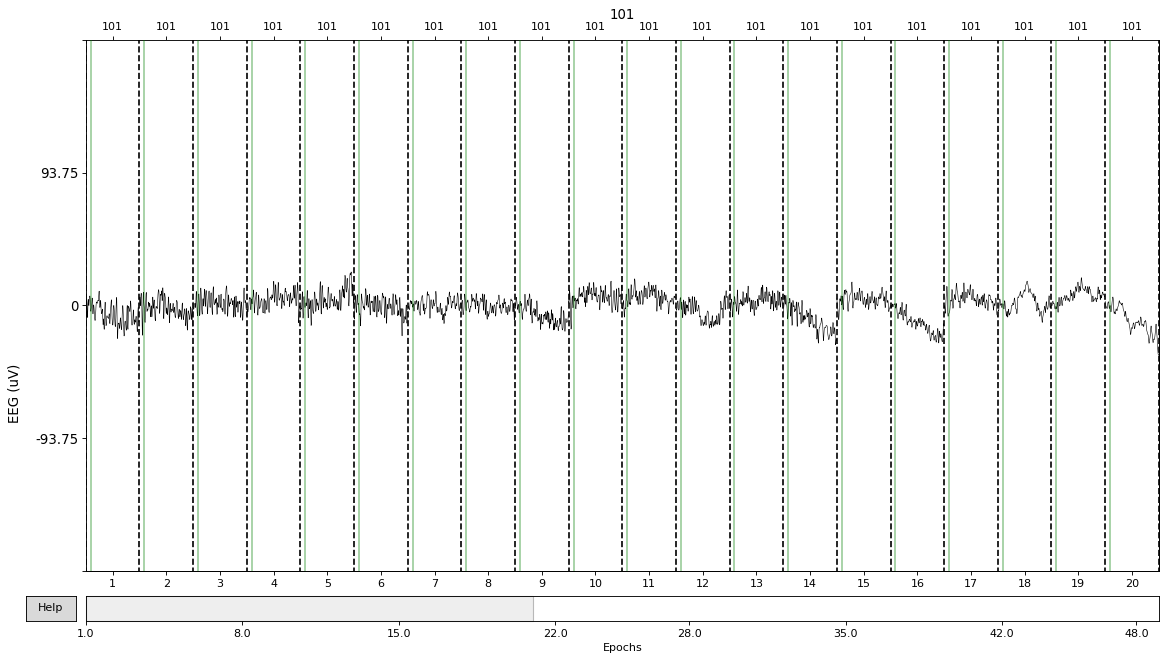

In [19]:
epochs_perc['101'].plot(picks=picks, butterfly=True)

In [ ]:
# Uses all MEG sensors and time points as separate classification
# features, so the resulting filters used are spatio-temporal

import itertools
import numpy as np
from sklearn.preprocessing import scale
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score
import numpy as np
import matplotlib.pyplot as plt

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

import mne
from mne.datasets import sample
from mne.decoding import (SlidingEstimator, GeneralizingEstimator, Scaler,
                          cross_val_multiscore, LinearModel, get_coef,
                          Vectorizer, CSP)

X = epochs_perc.get_data() 
y = epochs_perc.events[:, 2] 
combs = list(itertools.combinations(np.unique(y), 2))
X = mne.decoding.Scaler(epochs_perc.info).fit_transform(epochs_data=X)
X = Vectorizer().fit_transform(X)

svm = LinearSVC(C=1)
score = list()
#clf = make_pipeline(Scaler(epochs_perc.info),
                    #Vectorizer(),
                    #LogisticRegression(solver='lbfgs'))
for idx,comb in enumerate(combs):
    print(comb)
    this_X = X[np.logical_or(y==comb[0],y==comb[1]),:]
    this_y = y[np.logical_or(y==comb[0],y==comb[1])]
    score.append(cross_val_multiscore(svm, this_X, this_y, cv=12, n_jobs=1))



In [8]:
from scipy.spatial.distance import squareform
res = list(map(np.mean,score))
confusion = squareform(res)
print(f'Accuracy of the upright stimuli is {np.mean(squareform(confusion[0:50,0:50]))*100:.4f}%')
print(f'Accuracy of the upright unfamiliary stimuli is {np.mean(squareform(confusion[0:25,0:25]))*100:.4f}%')
print(f'Accuracy of the upright famous stimuli is {np.mean(squareform(confusion[25:50,25:50]))*100:.4f}%')
print(f'Accuracy of the inverted stimuli is {np.mean(squareform(confusion[50:,50:]))*100:.4f}%')
print(f'Accuracy of the inverted unfamiliar stimuli is {np.mean(squareform(confusion[50:75,50:75]))*100:.4f}%')
print(f'Accuracy of the inverted famous stimuli is {np.mean(squareform(confusion[75:,75:]))*100:.4f}%')
print(f'Accuracy of the entire set is {np.mean(squareform(confusion))*100:.4f}%')

Accuracy of the upright stimuli is 51.8044%
Accuracy of the upright unfamiliary stimuli is 52.5104%
Accuracy of the upright famous stimuli is 50.8021%
Accuracy of the inverted stimuli is 54.4864%
Accuracy of the inverted unfamiliar stimuli is 55.0833%
Accuracy of the inverted famous stimuli is 53.9132%
Accuracy of the entire set is 55.5638%


In [2]:
len(score)

NameError: name 'score' is not defined

In [3]:
this_X

NameError: name 'this_X' is not defined

In [ ]:
# Mean scores across cross-validation splits
score = np.mean(scores, axis=0)
print('Spatio-temporal: %0.1f%%' % (100 * score,))


### Running discrimination analysis

In [6]:
%run EEG_auxiliary_module.ipynb
times=[(0.05,0.65)]
results=[]# Loading first S08 session
durs=[];
for i in times:
    X, Y = convert_epochs_to_2D_array(epochs_perc, times=i)
    #Y = np.array(convert_lbl(Y))
    confusion, duration = run_eeg_svm(X, Y, 12)
    results.append(confusion)
    durs.append(duration)
    print(i)
    #np.save('/Users/dannem/Documents/Ilya_study/Analysis/conf_IR_02_S01_c.csv',confusion)
os.system('say "your program has finished"')
#results

Progress: [####################] 100.0%
The overall accuracy is 61.1 and the duration is 8.1 minutes
(0.05, 0.65)


0

### Presenting results

In [7]:
confusion=results[0]
from scipy.spatial.distance import squareform
print(f'Accuracy of the upright stimuli is {np.mean(squareform(confusion[0:50,0:50]))*100:.4f}%')
print(f'Accuracy of the upright unfamiliary stimuli is {np.mean(squareform(confusion[0:25,0:25]))*100:.4f}%')
print(f'Accuracy of the upright famous stimuli is {np.mean(squareform(confusion[25:50,25:50]))*100:.4f}%')
print(f'Accuracy of the inverted stimuli is {np.mean(squareform(confusion[50:,50:]))*100:.4f}%')
print(f'Accuracy of the inverted unfamiliar stimuli is {np.mean(squareform(confusion[50:75,50:75]))*100:.4f}%')
print(f'Accuracy of the inverted famous stimuli is {np.mean(squareform(confusion[75:,75:]))*100:.4f}%')
print(f'Accuracy of the entire set is {np.mean(squareform(confusion))*100:.4f}%')

## Correlation results
corr=np.corrcoef(squareform(confusion[0:25,0:25]),squareform(confusion[50:75,50:75]))
print(f'Correlation between identity discrimination in upright and inverted famous faces is {corr[0,1]:.3f}')
corr=np.corrcoef(squareform(confusion[25:50,25:50]),squareform(confusion[75:100,75:100]))
print(f'Correlation between identity discrimination in upright and inverted unfamiliar faces is {corr[0,1]:.3f}')
conf['perc'] = results[0]
file_name='conf_mat_perc_10.csv'
fname = op.join(outfolder,file_name)
np.savetxt(fname, conf['perc'], delimiter=',')


Accuracy of the upright stimuli is 55.0340%
Accuracy of the upright unfamiliary stimuli is 56.2500%
Accuracy of the upright famous stimuli is 53.6250%
Accuracy of the inverted stimuli is 57.5238%
Accuracy of the inverted unfamiliar stimuli is 59.6806%
Accuracy of the inverted famous stimuli is 55.2222%
Accuracy of the entire set is 61.0985%
Correlation between identity discrimination in upright and inverted famous faces is 0.007
Correlation between identity discrimination in upright and inverted unfamiliar faces is 0.007


# Data reduction

In [ ]:
from sklearn.decomposition import PCA, FastICA

X = epochs_02.get_data()
pca = UnsupervisedSpatialFilter(PCA(30), average=False)
pca_data = pca.fit_transform(X)
ev = mne.EvokedArray(np.mean(pca_data, axis=0),
                     mne.create_info(30, epochs.info['sfreq'],
                                     ch_types='eeg'), tmin=tmin)
ev.plot(show=False, window_title="PCA", time_unit='s')


In [ ]:
epochs_02.drop_bad()
epochs_02.plot_drop_log()

## Plotting

In [20]:
from mne.viz import plot_epochs_image
picks='PO8'
#epochs_02['120'].plot(block=True,picks=picks)
trigs=list(range(101,151))+list(range(201,251))
#trigs=list(range(31, 36))
trigs=[str(x) for x in trigs]
for i in trigs[:10]:
    plot_epochs_image(epochs[i], picks=picks, vmin=-100, vmax=750)


In [40]:
plot_epochs_image(epochs_02['35'], picks=picks, vmin=-100, vmax=750)

[<Figure size 640x480 with 4 Axes>]

In [ ]:
classes = set(Y)
fig, ax = plt.subplots(1)
im = ax.matshow(confusion, cmap='RdBu_r', clim=[0.3, 0.7])
ax.set_yticks(range(len(classes)))
ax.set_xticks(range(len(classes)))
ax.axhline(50, color='k')
ax.axvline(50, color='k')
plt.colorbar(im)
plt.tight_layout()
plt.show()

# Tools

In [ ]:
who_ls

In [ ]:
import mne
import numpy as np
import os.path as op

# Loading first ND sessioin
file_name='IR_02_S03.bdf'
file_folder='/Users/dannem/Documents/Ilya_study/Data'
fname = op.join(file_folder,file_name)
montage = mne.channels.read_montage("standard_1020")
raw = mne.io.read_raw_bdf(fname,montage=montage,
                              preload=True)
events = mne.find_events(raw, initial_event=True, 
                                 consecutive=True, shortest_event=1)
unique, counts = np.unique(events[:,2], return_counts=True)
print(list(zip(unique,counts)))

## Loading data

In [ ]:
# Loading first ND sessioin
file_name='IR_01_Pilot_a.bdf'
file_folder='/Users/dannem/Documents/Ilya_study/Data'
fname = op.join(file_folder,file_name)

# Load events
events=np.genfromtxt('/Users/dannem/Documents/Ilya_study/Data/01_inv_recon_2019_May_13_1027_fixed_triggers.csv',delimiter=',')
events=events.astype('int32')

# Load data
epochs_01_a = preprocessing_eeg(fname, event_ids, events=events, segment_times=(-0.1,1.8))
X, Y = convert_epochs_to_2D_array(epochs_01_a, times=(0.05,0.65), dims=(1,2),threshold=3)
confusion, duration = run_eeg_svm(X,Y,5)

In [ ]:
# Loading third ND sessioin
file_name='triggers_test.bdf'
file_folder='/Users/dannem/Documents/Ilya_study/Data'
fname = op.join(file_folder,file_name)

# Load data
epochs_01_c = preprocessing_eeg(fname, event_ids, crop=(4020,None))
X, Y = convert_epochs_to_2D_array(epochs_01_c, times=(0.05,0.65), dims=(0,1),threshold=3)
confusion, duration = run_eeg_svm(X,Y,5)

# Correlation analysis

## Theoretical observer

In [55]:
import pandas as pd
from scipy.spatial.distance import squareform, pdist
%run EEG_auxiliary_module.ipynb
pr_names = ['adi','ani','ama','ago','aza','ekl','evu','epo','eiv','ech','ian','jpi','kda',
           'kgo','mbo','mbe','ofa','pan','pga','rga','siv','tar','tka','yst','ype','ase',
           'aha','ake','cmo','eol','epa','ecl','ero','est','ewa','jla','jal','kpe','kkn',
            'kst','mcy','ndo','npo','owi','pcr','rmc','rwi','sjo','sgo','tsw']
folder1 = '/Users/dannem/Documents/Ilya_study/builder_exp/set3/east'
folder2 = '/Users/dannem/Documents/Ilya_study/builder_exp/set3/west'
df = pd.concat((image_to_df(folder1),image_to_df(folder2)))
df['origin'] = ['east']*25+['west']*25
conf = squareform(pdist(df.iloc[:,:16428],'euclidean'))
df_to = pd.DataFrame(conf, columns = pr_names, index = pr_names)
df_to.head()

,adi,ani,ama,ago,aza,ekl,evu,epo,eiv,ech,...,mcy,ndo,npo,owi,pcr,rmc,rwi,sjo,sgo,tsw
adi,0.000000,4489.830620,4906.270580,5824.954420,5041.518918,4902.574630,6559.865852,5153.931412,4898.938661,4938.098521,...,6179.602333,5206.228481,5200.888962,4214.418465,5110.767261,5469.482517,5010.585994,5338.719697,3974.510033,5340.549691
ani,4489.830620,0.000000,3678.950937,4600.964573,4966.770983,3645.270498,5977.966962,4063.287093,3810.175980,4916.795501,...,5458.893294,4403.315569,4008.828632,4237.505634,5338.092262,4638.537269,3899.542409,4411.413719,4336.921604,5081.374617
ama,4906.270580,3678.950937,0.000000,4477.460776,4191.213667,3719.249790,5448.596608,3872.432311,3812.488033,4957.694222,...,5577.925062,3924.070591,3463.431680,4122.003154,5724.599986,4180.841542,3669.757621,4172.211764,4085.084944,4495.145826
ago,5824.954420,4600.964573,4477.460776,0.000000,4882.191823,4922.978773,4671.313092,4064.447195,5281.285071,4832.364742,...,5208.031970,4370.819717,4079.677193,4656.617549,6030.401313,5020.225991,4441.640463,5939.213921,5124.202572,5212.722225
aza,5041.518918,4966.770983,4191.213667,4882.191823,0.000000,4940.260418,6281.366810,4748.503554,5196.898594,4598.368624,...,5602.227771,4571.685466,5007.937999,4311.325086,5765.930541,5289.494872,4554.444313,5223.437278,4496.814984,5630.589667


In [215]:
type(data)

numpy.ndarray

In [75]:
# Comparing confusibility matrices
import pandas as pd
from scipy.spatial.distance import squareform
file_name='conf_mat.npy'
fname = op.join(file_folder,file_name)
conf = np.load(fname, allow_pickle =  True).item()
im_names = ['mcy','sgo','sjo','est','tsw']
corr_names = ['est','mcy','sjo','sgo','tsw']
pr_names = ['adi','ani','ama','ago','aza','ekl','evu','epo','eiv','ech','ian','jpi','kda',
           'kgo','mbo','mbe','ofa','pan','pga','rga','siv','tar','tka','yst','ype','ase',
           'aha','ake','cmo','eol','epa','ecl','ero','est','ewa','jla','jal','kpe','kkn',
            'kst','mcy','ndo','npo','owi','pcr','rmc','rwi','sjo','sgo','tsw']
df_imag = pd.DataFrame(conf['imag'][1],columns = im_names, index = im_names)
df_perc = pd.DataFrame(conf['perc'])
df_perc.columns = [pr_names*2]
df_perc.index = [pr_names*2]
idx = pd.IndexSlice
df_perc_imag = df_perc.loc[idx[im_names], idx[im_names]]
print(df_imag.head())
df_imag = df_imag.reindex(corr_names)
df_imag = df_imag.transpose().reindex(corr_names).transpose()
df_imag.head()
df_to_imag = df_to.loc[idx[im_names], idx[im_names]]
df_to_imag = df_to_imag.reindex(corr_names)
df_to_imag = df_to_imag.transpose().reindex(corr_names).transpose()
# compute correlations
up_corr = np.corrcoef(squareform(df_imag),squareform(df_perc_imag.iloc[:5,:5].values))
print(f'Correlation between upright percieved and imagary discrimination is {up_corr[1,0]:.2f}')
in_corr = np.corrcoef(squareform(df_imag),squareform(df_perc_imag.iloc[-5:,-5:].values))
print(f'Correlation between inverted percieved and imagary discriminations is {in_corr[1,0]:.2f}')

to_imag_corr = np.corrcoef(squareform(df_to_imag),squareform(df_imag.iloc[:5,:5].values))
print(f'Correlation between imagery and TO {to_imag_corr[1,0]:.2f}')


up_perc_to_corr = np.corrcoef(squareform(df_to.values),squareform(df_perc.iloc[:50,:50].values))
print(f'Correlation between upright percieved and TO discriminations is {up_perc_to_corr[1,0]:.2f}')
in_perc_to_corr = np.corrcoef(squareform(df_to.values),squareform(df_perc.iloc[50:100,50:100].values))
print(f'Correlation between inverted percieved and TO discriminations is {in_perc_to_corr[1,0]:.2f}')
up_perc_to_corr_unf = np.corrcoef(squareform(df_to.values[:25,:25]),squareform(df_perc.iloc[:25,:25].values))
print(f'Correlation between unfamiliar upright percieved and TO discriminations is {up_perc_to_corr_unf[1,0]:.2f}')
up_perc_to_corr_fam = np.corrcoef(squareform(df_to.values[25:50,25:50]),squareform(df_perc.iloc[25:50,25:50].values))
print(f'Correlation between famous upright percieved and TO discriminations is {up_perc_to_corr_fam[1,0]:.2f}')

in_perc_to_corr_unf = np.corrcoef(squareform(df_to.values[:25,:25]),squareform(df_perc.iloc[50:75,50:75].values))
print(f'Correlation between unfamiliar inverted percieved and TO discriminations is {in_perc_to_corr_unf[1,0]:.2f}')
in_perc_to_corr_fam = np.corrcoef(squareform(df_to.values[25:50,25:50]),squareform(df_perc.iloc[75:100,75:100].values))
print(f'Correlation between famous inverted percieved and TO discriminations is {in_perc_to_corr_fam[1,0]:.2f}')

          mcy       sgo       sjo       est       tsw
mcy  0.000000  0.541667  0.541667  0.645833  0.458333
sgo  0.541667  0.000000  0.625000  0.645833  0.708333
sjo  0.541667  0.625000  0.000000  0.583333  0.812500
est  0.645833  0.645833  0.583333  0.000000  0.541667
tsw  0.458333  0.708333  0.812500  0.541667  0.000000
Correlation between upright percieved and imagary discrimination is -0.34
Correlation between inverted percieved and imagary discriminations is 0.06
Correlation between imagery and TO -0.22
Correlation between upright percieved and TO discriminations is 0.05
Correlation between inverted percieved and TO discriminations is 0.14
Correlation between unfamiliar upright percieved and TO discriminations is 0.12
Correlation between famous upright percieved and TO discriminations is -0.01
Correlation between unfamiliar inverted percieved and TO discriminations is 0.18
Correlation between famous inverted percieved and TO discriminations is 0.07


In [65]:
df_to_imag

,est,mcy,sjo,sgo,tsw
est,0.000000,6328.464348,5693.663847,4520.609251,5391.608387
mcy,6328.464348,0.000000,6230.088844,5487.058502,5303.310287
sjo,5693.663847,6230.088844,0.000000,4853.069956,5463.593232
sgo,4520.609251,5487.058502,4853.069956,0.000000,4715.132766
tsw,5391.608387,5303.310287,5463.593232,4715.132766,0.000000


In [55]:
len(list(zip(pr_names*2, ['east']*25+['west']*25)))

50

In [61]:
np.tile(['east']*25+['west']*25,2)

array(['east', 'east', 'east', 'east', 'east', 'east', 'east', 'east',
       'east', 'east', 'east', 'east', 'east', 'east', 'east', 'east',
       'east', 'east', 'east', 'east', 'east', 'east', 'east', 'east',
       'east', 'west', 'west', 'west', 'west', 'west', 'west', 'west',
       'west', 'west', 'west', 'west', 'west', 'west', 'west', 'west',
       'west', 'west', 'west', 'west', 'west', 'west', 'west', 'west',
       'west', 'west', 'east', 'east', 'east', 'east', 'east', 'east',
       'east', 'east', 'east', 'east', 'east', 'east', 'east', 'east',
       'east', 'east', 'east', 'east', 'east', 'east', 'east', 'east',
       'east', 'east', 'east', 'west', 'west', 'west', 'west', 'west',
       'west', 'west', 'west', 'west', 'west', 'west', 'west', 'west',
       'west', 'west', 'west', 'west', 'west', 'west', 'west', 'west',
       'west', 'west', 'west', 'west'], dtype='<U4')

In [53]:
from scipy.spatial.distance import squareform, pdist
Y = squareform(pdist(df.iloc[:,:16428],'euclidean'))
Y.shape

(50, 50)

In [69]:
df_perc_imag.iloc[:5,:5].values

array([[0.        , 0.81818182, 0.77272727, 0.77272727, 0.45454545],
       [0.81818182, 0.        , 0.77272727, 0.63636364, 0.86363636],
       [0.77272727, 0.77272727, 0.        , 0.45454545, 0.45454545],
       [0.77272727, 0.63636364, 0.45454545, 0.        , 0.77272727],
       [0.45454545, 0.86363636, 0.45454545, 0.77272727, 0.        ]])

In [72]:
df_imag

,est,mcy,sjo,sgo,tsw
est,0.000000,0.645833,0.583333,0.645833,0.541667
mcy,0.645833,0.000000,0.541667,0.541667,0.458333
sjo,0.583333,0.541667,0.000000,0.625000,0.812500
sgo,0.645833,0.541667,0.625000,0.000000,0.708333
tsw,0.541667,0.458333,0.812500,0.708333,0.000000


In [73]:
df_perc.head(n=50)

,adi,ani,ama,ago,aza,ekl,evu,epo,eiv,ech,...,mcy,ndo,npo,owi,pcr,rmc,rwi,sjo,sgo,tsw
adi,0.000000,0.227273,0.500000,0.363636,0.500000,0.409091,0.272727,0.545455,0.318182,0.500000,...,0.681818,0.772727,0.681818,0.545455,0.772727,0.772727,0.636364,0.636364,0.772727,0.545455
ani,0.227273,0.000000,0.545455,0.363636,0.454545,0.363636,0.318182,0.590909,0.227273,0.409091,...,0.727273,0.500000,0.636364,0.363636,0.363636,0.727273,0.545455,0.590909,0.681818,0.636364
ama,0.500000,0.545455,0.000000,0.590909,0.409091,0.500000,0.500000,0.636364,0.363636,0.636364,...,0.909091,0.818182,0.727273,0.727273,0.909091,1.000000,0.818182,0.818182,0.909091,0.772727
ago,0.363636,0.363636,0.590909,0.000000,0.409091,0.590909,0.454545,0.727273,0.545455,0.590909,...,0.772727,0.772727,0.818182,0.727273,0.909091,0.727273,0.863636,0.772727,0.954545,0.727273
aza,0.500000,0.454545,0.409091,0.409091,0.000000,0.409091,0.454545,0.681818,0.590909,0.500000,...,0.863636,0.590909,0.681818,0.500000,0.863636,0.636364,0.681818,0.727273,0.909091,0.727273
ekl,0.409091,0.363636,0.500000,0.590909,0.409091,0.000000,0.454545,0.500000,0.318182,0.681818,...,0.636364,0.636364,0.545455,0.545455,0.590909,0.545455,0.590909,0.500000,0.727273,0.500000
evu,0.272727,0.318182,0.500000,0.454545,0.454545,0.454545,0.000000,0.500000,0.454545,0.818182,...,0.909091,0.818182,0.772727,0.727273,0.772727,0.863636,0.772727,0.590909,0.954545,0.636364
epo,0.545455,0.590909,0.636364,0.727273,0.681818,0.500000,0.500000,0.000000,0.272727,0.772727,...,0.909091,0.681818,0.818182,0.681818,0.681818,0.909091,0.772727,0.681818,0.772727,0.500000
eiv,0.318182,0.227273,0.363636,0.545455,0.590909,0.318182,0.454545,0.272727,0.000000,0.590909,...,0.636364,0.590909,0.500000,0.590909,0.590909,0.636364,0.681818,0.545455,0.863636,0.636364
ech,0.500000,0.409091,0.636364,0.590909,0.500000,0.681818,0.818182,0.772727,0.590909,0.000000,...,0.909091,0.818182,0.818182,0.681818,0.727273,0.772727,0.727273,0.636364,0.727273,0.681818


In [ ]:
epochs = mne.read_epochs('F:\\EEG_analysis\\S04_perc.fif')

Progress: [####################] 100.0%
 The duration is 1.3 minutes


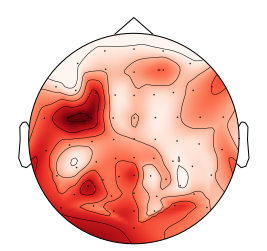

(<matplotlib.image.AxesImage at 0x831560da0>,
 <matplotlib.contour.QuadContourSet at 0x831571198>)

In [3]:
# features for perception map
%run EEG_auxiliary_module.ipynb
X, Y = convert_epochs_to_2D_array(epochs_perc[[str(x) for x in range(101,126)]], times=(0.05,0.65))
#X, Y = convert_epochs_to_2D_array(epochs_perc, times=(0.05,0.65))
coef, duration = run_svm_coef(X,Y)
%matplotlib inline
coefs=np.mean(np.abs(np.array(coef)),0)
fig, (ax1, ax2) = plt.subplots(1, 2)
mne.viz.plot_topomap(coefs,epochs_perc.info,vmin=np.min(coefs))
